In [45]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer, TimeDistributed
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

import random

# Define the path to the VCTK corpus
data_path = r".\dataset" # Update this path to your dataset location

# Load speaker info
data = []
with open(os.path.join(data_path, 'speaker-info.txt'), 'r') as f:
    lines = f.readlines()
    # Skip the header
    lines = lines[1:]
    for line in lines:
        line = line.strip()
        if not line:
            continue
        # Split the line into parts
        parts = line.split()
        if len(parts) >= 5:
            ID = parts[0]
            AGE = parts[1]
            GENDER = parts[2]
            ACCENTS = parts[3]
            REGION = ' '.join(parts[4:])
            data.append([ID, AGE, GENDER, ACCENTS, REGION])
        else:
            # Handle lines with missing data
            print(f"Line skipped due to insufficient columns: {line}")
            continue

# Create DataFrame
column_names = ['ID', 'AGE', 'GENDER', 'ACCENTS', 'REGION']
speaker_info = pd.DataFrame(data, columns=column_names)

# Strip whitespace from columns
for col in column_names:
    speaker_info[col] = speaker_info[col].str.strip()

# Convert ID to int
speaker_info['ID'] = speaker_info['ID'].astype(int)

# Print unique GENDER values
print("Unique GENDER values:")
for val in speaker_info['GENDER'].unique():
    print(f"'{val}' (length {len(val)})")

# Now filter male and female speakers
male_speakers = speaker_info[speaker_info['GENDER'] == 'M']['ID'].tolist()
female_speakers = speaker_info[speaker_info['GENDER'] == 'F']['ID'].tolist()

print("Number of male speakers:", len(male_speakers))
print("Number of female speakers:", len(female_speakers))

# Combine male and female speakers
all_speakers = male_speakers + female_speakers

# Convert IDs to string with 'p' prefix and zero-padding
all_speakers = ['p' + str(int(id)).zfill(3) for id in all_speakers]

# Shuffle the list
np.random.seed(42)
np.random.shuffle(all_speakers)

# Total number of speakers
total_speakers = len(all_speakers)
print("Total number of speakers:", total_speakers)

# Calculate the number of speakers for each set
train_size = int(0.8 * total_speakers)
val_size = int(0.1 * total_speakers)
test_size = total_speakers - train_size - val_size  # Ensure all speakers are included

# Split the speakers
train_speakers = all_speakers[:train_size]
val_speakers = all_speakers[train_size:train_size + val_size]
test_speakers = all_speakers[train_size + val_size:]

print(f"Training Speakers ({len(train_speakers)}): {train_speakers}")
print(f"Validation Speakers ({len(val_speakers)}): {val_speakers}")
print(f"Testing Speakers ({len(test_speakers)}): {test_speakers}")



Line skipped due to insufficient columns: 248  23  F    Indian
Line skipped due to insufficient columns: 251  26  M    Indian
Line skipped due to insufficient columns: 329  23  F    American
Line skipped due to insufficient columns: 330  26  F    American
Line skipped due to insufficient columns: 362  29  F    American
Line skipped due to insufficient columns: 376  22  M    Indian
Unique GENDER values:
'F' (length 1)
'M' (length 1)
Number of male speakers: 45
Number of female speakers: 57
Total number of speakers: 102
Training Speakers (81): ['p292', 'p268', 'p262', 'p229', 'p363', 'p347', 'p317', 'p225', 'p254', 'p226', 'p271', 'p298', 'p340', 'p308', 'p295', 'p241', 'p300', 'p304', 'p256', 'p284', 'p351', 'p238', 'p275', 'p269', 'p374', 'p341', 'p260', 'p288', 'p345', 'p252', 'p307', 'p255', 'p361', 'p240', 'p286', 'p265', 'p243', 'p299', 'p266', 'p315', 'p263', 'p318', 'p311', 'p246', 'p364', 'p283', 'p285', 'p272', 'p306', 'p281', 'p297', 'p231', 'p258', 'p279', 'p237', 'p270', 'p3

In [46]:
# Function to load audio files
def load_audio_files(speaker_list, num_sentences_per_speaker, data_path):
    audio_data = []
    for speaker in speaker_list:
        speaker_path = os.path.join(data_path, 'wav48', speaker)
        if not os.path.exists(speaker_path):
            print(f"Speaker folder not found: {speaker_path}")
            continue
        files = os.listdir(speaker_path)
        wav_files = [f for f in files if f.endswith('.wav')]
        wav_files.sort()
        # Select a subset if necessary
        wav_files = wav_files[:num_sentences_per_speaker]
        for wav_file in wav_files:
            file_path = os.path.join(speaker_path, wav_file)
            y, sr = librosa.load(file_path, sr=16000)  # Resample to 16kHz
            audio_data.append(y)
    return audio_data

# Define the number of sentences per speaker
num_sentences_per_speaker = 20  # Adjust as needed

# Load training data
train_audio = load_audio_files(train_speakers, num_sentences_per_speaker, data_path)
print("Loaded training audio samples:", len(train_audio))

# Load validation data
val_audio = load_audio_files(val_speakers, num_sentences_per_speaker, data_path)
print("Loaded validation audio samples:", len(val_audio))

# Load testing data
test_audio = load_audio_files(test_speakers, num_sentences_per_speaker, data_path)
print("Loaded testing audio samples:", len(test_audio))

Loaded training audio samples: 1620
Loaded validation audio samples: 200
Loaded testing audio samples: 220


In [47]:
# ... [Previous code for data loading and processing] ...

# 1. Load Noise Files
import os
import librosa

# Define the path to the noise files
noise_path = r".\\dataset\\Noise"   # Adjust if necessary

# List of noise filenames
noise_filenames = noise_filenames = [
    'big-explosion_G_minor.wav', 'car-crash-sound-fx_127bpm.wav', 
    'cartoon-sound-fx-noise-3_103bpm.wav', 'clap-loud_D_major.wav', 
    'gun-bass-old-glitchy-gun.wav', 'gun-shot_100bpm_D_minor.wav', 
    'police-siren_A_minor.wav', 'snare-hit-hard-3.wav', 
    'sound-fx-sub-static-long-tail.wav'
]

# Load noise files
def load_noise_files(noise_path, noise_filenames, sr=16000):
    noise_list = []
    for filename in noise_filenames:
        filepath = os.path.join(noise_path, filename)
        if os.path.exists(filepath):
            noise_audio, _ = librosa.load(filepath, sr=sr)
            noise_list.append(noise_audio)
        else:
            print(f"Noise file not found: {filepath}")
    return noise_list

# Load the noise files
noise_list = load_noise_files(noise_path, noise_filenames)
print(f"Loaded {len(noise_list)} noise files.")

# 2. Define SNR Levels
snr_levels = [-5, 0, 5]  # Varying SNR levels

# 3. Add Transient Noises and Compute Masks
def add_transient_noise_to_audio(audio_list, noise_list, snr_levels, sr=16000, n_mels=64):
    features = []
    clean_masks = []
    for audio in audio_list:
        audio_length = len(audio)
        
        # Randomly select a noise
        if len(noise_list) == 0:
            print("No noise files available.")
            continue
        noise_audio = noise_list[np.random.randint(len(noise_list))]
        
        # Ensure the noise fits within the audio length
        if len(noise_audio) >= audio_length:
            # Randomly select a segment of the noise
            start_idx = np.random.randint(0, len(noise_audio) - audio_length + 1)
            noise_segment = noise_audio[start_idx:start_idx + audio_length]
        else:
            # Pad the noise to match the audio length
            noise_segment = np.tile(noise_audio, int(np.ceil(audio_length / len(noise_audio))))[:audio_length]
        
        # Randomly select SNR level
        snr_db = np.random.choice(snr_levels)
        snr_linear = 10 ** (snr_db / 20)
        
        # Scale the noise to achieve the desired SNR
        rms_signal = np.sqrt(np.mean(audio ** 2))
        rms_noise = np.sqrt(np.mean(noise_segment ** 2))
        noise_segment = noise_segment * (rms_signal / (rms_noise * snr_linear))
        
        # Create the noisy audio
        noisy = audio + noise_segment
        
        # Compute mel spectrograms of clean and noisy audio
        S_clean = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
        S_noisy = librosa.feature.melspectrogram(y=noisy, sr=sr, n_mels=n_mels)
        
        # Compute IRM in the time-frequency domain
        eps = 1e-8
        irm = np.minimum(1.0, S_clean / (S_noisy + eps))
        
        # Convert the noisy spectrogram to dB scale
        S_noisy_dB = librosa.power_to_db(S_noisy, ref=np.max)
        
        # Transpose to have time steps first
        features.append(S_noisy_dB.T)
        clean_masks.append(irm.T)
    return features, clean_masks

# Define STR range from -5 dB to -20 dB
str_range = (-20, -5)

# Add transient noises to training data
train_features, train_masks = add_transient_noise_to_audio(train_audio, noise_list, snr_levels)
print("Created noisy training audio samples:", len(train_features))

# Add transient noises to validation data
val_features, val_masks = add_transient_noise_to_audio(val_audio, noise_list, snr_levels)
print("Created noisy validation audio samples:", len(val_features))

# Add transient noises to testing data
test_features, test_masks = add_transient_noise_to_audio(test_audio, noise_list, snr_levels)
print("Created noisy testing audio samples:", len(test_features))


Loaded 9 noise files.
Created noisy training audio samples: 1620
Created noisy validation audio samples: 200
Created noisy testing audio samples: 220


In [48]:
# Pad sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Find the maximum timesteps across all datasets
max_timesteps = max(
    max([feature.shape[0] for feature in train_features]),
    max([feature.shape[0] for feature in val_features]),
    max([feature.shape[0] for feature in test_features])
)

# Pad the sequences
train_features_padded = pad_sequences(train_features, maxlen=max_timesteps, dtype='float32', padding='post')
train_masks_padded = pad_sequences(train_masks, maxlen=max_timesteps, dtype='float32', padding='post')

val_features_padded = pad_sequences(val_features, maxlen=max_timesteps, dtype='float32', padding='post')
val_masks_padded = pad_sequences(val_masks, maxlen=max_timesteps, dtype='float32', padding='post')

test_features_padded = pad_sequences(test_features, maxlen=max_timesteps, dtype='float32', padding='post')
test_masks_padded = pad_sequences(test_masks, maxlen=max_timesteps, dtype='float32', padding='post')

# Build the LSTM Model
n_features = train_features_padded.shape[2]

model = Sequential()
model.add(InputLayer(input_shape=(max_timesteps, n_features)))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(TimeDistributed(Dense(n_features, activation='sigmoid')))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 471, 128)          98816     
                                                                 
 lstm_9 (LSTM)               (None, 471, 64)           49408     
                                                                 
 time_distributed_4 (TimeDis  (None, 471, 64)          4160      
 tributed)                                                       
                                                                 
Total params: 152,384
Trainable params: 152,384
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
51/51 [==============================] - 44s 809ms/step - loss: 0.1167 - val_loss: 0.0650
Epoch 2/5
51/51 [==============================] - 34s 669ms/step - loss: 0.0525 - val_loss: 0.0508
Epoch 3/5
51/51 [==============================] - 41s 813ms/step - loss: 0.0446 - val_loss: 0.0431
Epoch 4/5
51/51 [==============================] - 42s 828ms/step - loss: 0.0394 - val_loss: 0.0400
Epoch 5/5
51/51 [==============================] - 42s 818ms/step - loss: 0.0368 - val_loss: 0.0394


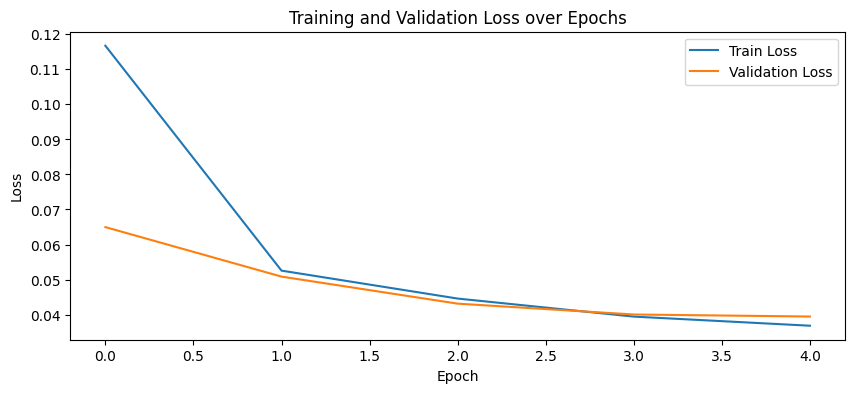

In [49]:
# Train the Model
epochs = 5
batch_size = 32

history = model.fit(
    train_features_padded, train_masks_padded,
    validation_data=(val_features_padded, val_masks_padded),
    epochs=epochs,
    batch_size=batch_size
)

# Plot Training History
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


7/7 [==============================] - 3s 484ms/step - loss: 0.0400
Test Loss (MSE): 0.040047
1/1 [==============================] - 1s 619ms/step


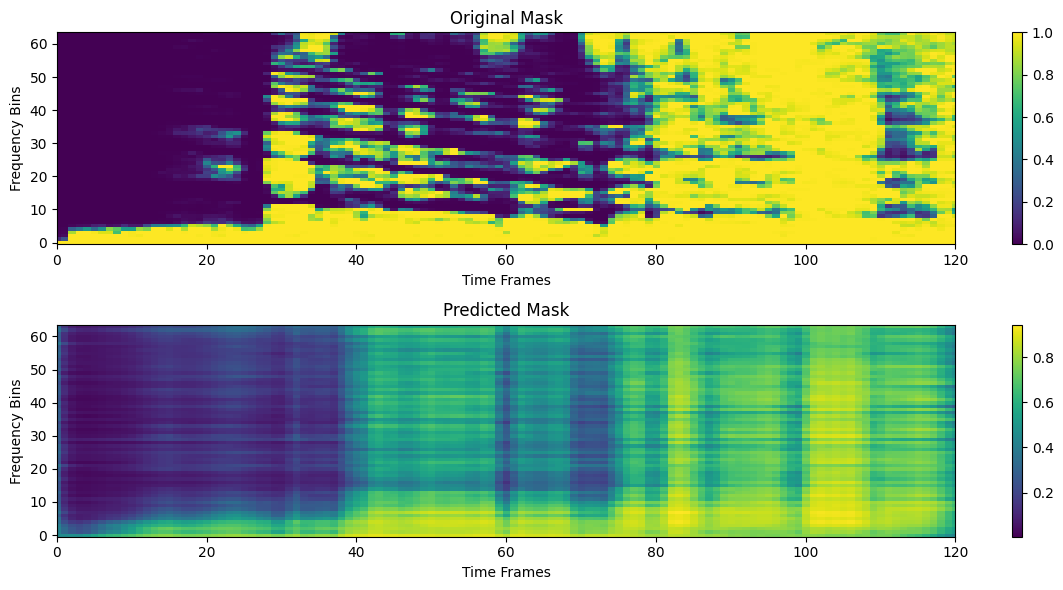

Original Noisy Audio:


Enhanced Audio:


Clean Audio:


In [50]:
# Evaluate the model on the testing set
test_loss = model.evaluate(test_features_padded, test_masks_padded, batch_size=batch_size)
print(f"Test Loss (MSE): {test_loss:.6f}")

# Select a test sample
test_sample_index = 3  # Change this index to test different samples
test_sample = test_features_padded[test_sample_index:test_sample_index + 1]
test_mask = test_masks_padded[test_sample_index:test_sample_index + 1]

# Predict the mask
predicted_mask = model.predict(test_sample)

import matplotlib.pyplot as plt

# Visualize the original mask and predicted mask
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.title('Original Mask')
plt.imshow(test_mask.squeeze().T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar()
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')
plt.xlim(0,120)

plt.subplot(2, 1, 2)
plt.title('Predicted Mask')
plt.imshow(predicted_mask.squeeze().T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar()
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')
plt.xlim(0,120)


plt.tight_layout()
plt.show()

import librosa

# Get the noisy spectrogram for the test sample
noisy_spectrogram = test_sample.squeeze().T  # Shape: (n_mels, time_steps)

# Convert back from dB to power
noisy_spectrogram_power = librosa.db_to_power(noisy_spectrogram)

# Apply the predicted mask
enhanced_spectrogram_power = noisy_spectrogram_power * predicted_mask.squeeze().T

# Reconstruct the enhanced audio
enhanced_audio = librosa.feature.inverse.mel_to_audio(
    enhanced_spectrogram_power,
    sr=16000,
    n_fft=1024,
    hop_length=512,
    power=1.0,
    n_iter=32,
)

# Original noisy audio for comparison
# Reconstruct the noisy audio from the spectrogram
noisy_audio = librosa.feature.inverse.mel_to_audio(
    noisy_spectrogram_power,
    sr=16000,
    n_fft=1024,
    hop_length=512,
    power=1.0,
    n_iter=32,
)

# Clean audio for reference
# Since we have the original clean audio, we can use it directly
clean_audio = test_audio[test_sample_index]

from IPython.display import Audio, display

print("Original Noisy Audio:")
display(Audio(noisy_audio, rate=16000))

print("Enhanced Audio:")
display(Audio(enhanced_audio, rate=16000))

print("Clean Audio:")
display(Audio(clean_audio, rate=16000))



SNR of Noisy Audio: -0.49 dB
SNR of Enhanced Audio: 0.09 dB
SNR Improvement: 0.58 dB
Mean Squared Error (MSE): 0.005139
PESQ Score: 1.14
STOI Score: 0.58


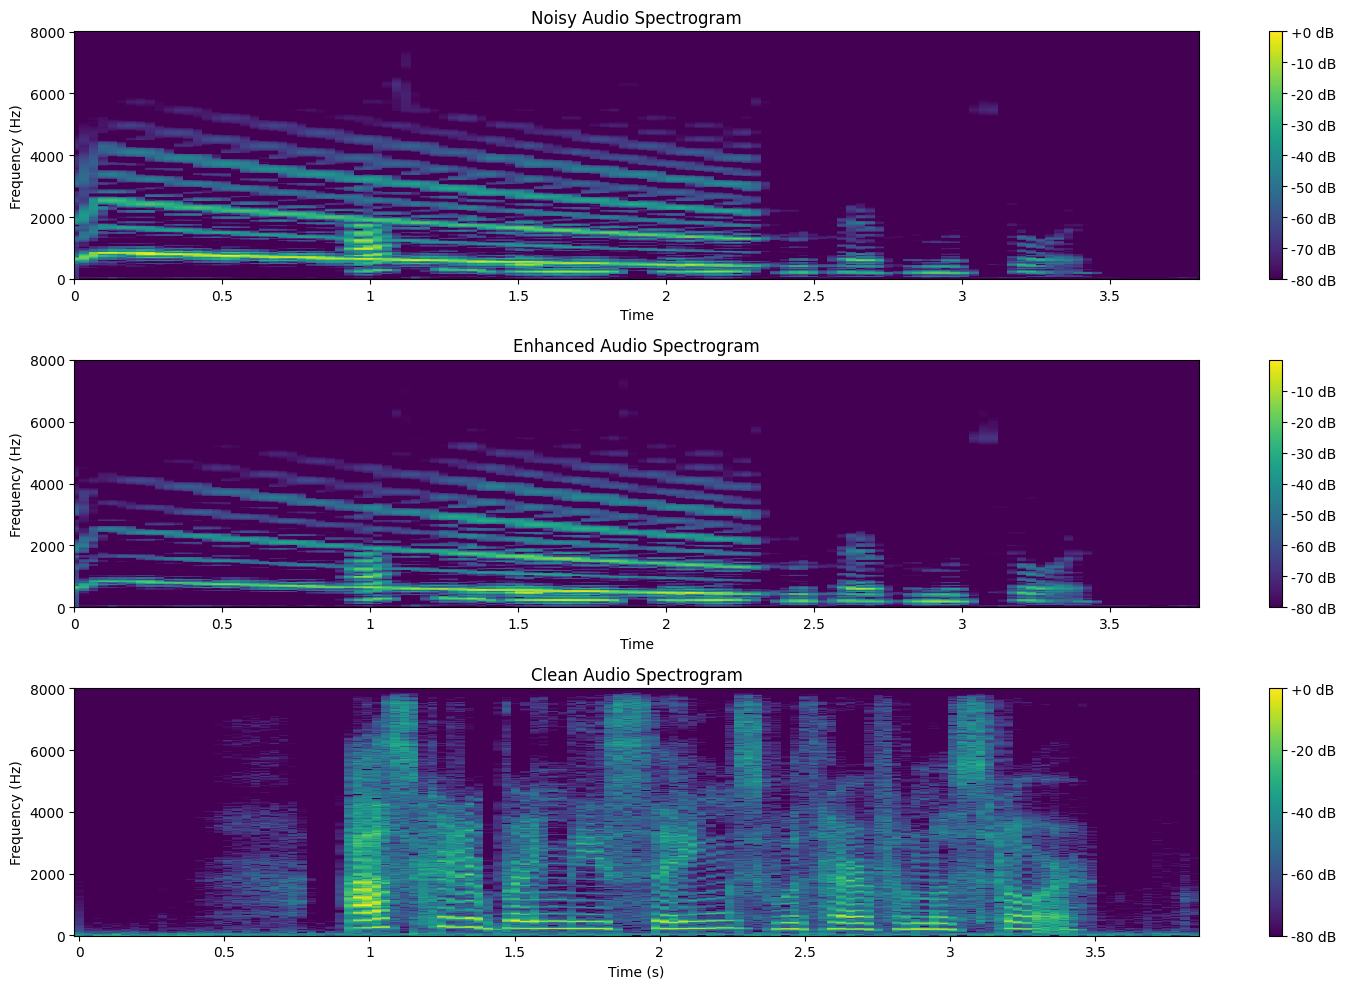

In [51]:
# Compute Performance Metrics

# Compute SNR Improvement
def compute_snr(clean_signal, processed_signal):
    # Ensure the signals are the same length
    min_len = min(len(clean_signal), len(processed_signal))
    clean_signal = clean_signal[:min_len]
    processed_signal = processed_signal[:min_len]
    
    # Compute signal power and noise power
    signal_power = np.sum(clean_signal ** 2)
    noise_power = np.sum((clean_signal - processed_signal) ** 2)
    snr = 10 * np.log10(signal_power / (noise_power + 1e-8))
    return snr

# Compute SNR of Noisy Audio
snr_noisy = compute_snr(clean_audio, noisy_audio)

# Compute SNR of Enhanced Audio
snr_enhanced = compute_snr(clean_audio, enhanced_audio)

# Calculate SNR Improvement
snr_improvement = snr_enhanced - snr_noisy

print(f"SNR of Noisy Audio: {snr_noisy:.2f} dB")
print(f"SNR of Enhanced Audio: {snr_enhanced:.2f} dB")
print(f"SNR Improvement: {snr_improvement:.2f} dB")

#Compute Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error

# Ensure the signals are the same length
min_len = min(len(clean_audio), len(enhanced_audio))
clean_signal = clean_audio[:min_len]
enhanced_signal = enhanced_audio[:min_len]

# Compute MSE
mse = mean_squared_error(clean_signal, enhanced_signal)
print(f"Mean Squared Error (MSE): {mse:.6f}")

# Compute PSEQ
from pesq import pesq

# Compute PESQ
pesq_score = pesq(16000, clean_signal, enhanced_signal, 'wb')
print(f"PESQ Score: {pesq_score:.2f}")

# Compute STOI
from pystoi import stoi

# Compute STOI
stoi_score = stoi(clean_signal, enhanced_signal, 16000, extended=False)
print(f"STOI Score: {stoi_score:.2f}")

import librosa.display

# Compute spectrograms
# Noisy audio spectrogram
noisy_S = librosa.stft(noisy_audio, n_fft=1024, hop_length=512)
noisy_S_db = librosa.amplitude_to_db(np.abs(noisy_S), ref=np.max)

# Enhanced audio spectrogram
enhanced_S = librosa.stft(enhanced_audio, n_fft=1024, hop_length=512)
enhanced_S_db = librosa.amplitude_to_db(np.abs(enhanced_S), ref=np.max)

# Clean audio spectrogram
clean_S = librosa.stft(clean_audio, n_fft=1024, hop_length=512)
clean_S_db = librosa.amplitude_to_db(np.abs(clean_S), ref=np.max)

# Plotting
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
librosa.display.specshow(noisy_S_db, sr=16000, hop_length=512, x_axis='time', y_axis='hz', cmap='viridis')
plt.title('Noisy Audio Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.ylabel('Frequency (Hz)')
plt.xlim(0,3.8)

plt.subplot(3, 1, 2)
librosa.display.specshow(enhanced_S_db, sr=16000, hop_length=512, x_axis='time', y_axis='hz', cmap='viridis')
plt.title('Enhanced Audio Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.ylabel('Frequency (Hz)')
plt.xlim(0,3.8)

plt.subplot(3, 1, 3)
librosa.display.specshow(clean_S_db, sr=16000, hop_length=512, x_axis='time', y_axis='hz', cmap='viridis')
plt.title('Clean Audio Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

Epoch 1/5
51/51 [==============================] - 37s 734ms/step - loss: 0.0341 - val_loss: 0.0354
Epoch 2/5
51/51 [==============================] - 41s 802ms/step - loss: 0.0325 - val_loss: 0.0341
Epoch 3/5
51/51 [==============================] - 41s 813ms/step - loss: 0.0310 - val_loss: 0.0329
Epoch 4/5
51/51 [==============================] - 41s 797ms/step - loss: 0.0302 - val_loss: 0.0317
Epoch 5/5
51/51 [==============================] - 41s 811ms/step - loss: 0.0285 - val_loss: 0.0313
Total Training Time: 201.65 seconds
1/1 [==============================] - 0s 56ms/step
Inference Time for one sample: 0.0813 seconds
Epoch 1/5
51/51 [==============================] - 42s 835ms/step - loss: 0.0279 - val_loss: 0.0305
Epoch 2/5
51/51 [==============================] - 41s 812ms/step - loss: 0.0268 - val_loss: 0.0283
Epoch 3/5
51/51 [==============================] - 41s 811ms/step - loss: 0.0256 - val_loss: 0.0278
Epoch 4/5
51/51 [==============================] - 44s 856ms/step 

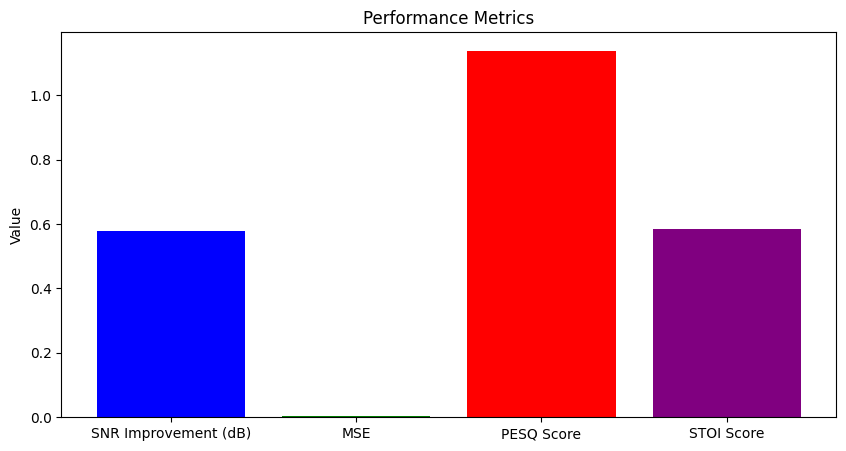

In [52]:
# Compare Performance vs. Computational Cost

# Measure Training Time
import time

# Record the start time
start_time = time.time()

# Train the Model
history = model.fit(
    train_features_padded, train_masks_padded,
    validation_data=(val_features_padded, val_masks_padded),
    epochs=epochs,
    batch_size=batch_size
)

# Record the end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print(f"Total Training Time: {training_time:.2f} seconds")


# Measure Training Time
# Record the start time
start_time = time.time()

# Predict the mask
predicted_mask = model.predict(test_sample)

# Record the end time
end_time = time.time()

# Calculate inference time
inference_time = end_time - start_time
print(f"Inference Time for one sample: {inference_time:.4f} seconds")

#Measure Memory usage
from memory_profiler import memory_usage

# Define a function to train the model
def train_model():
    model.fit(
        train_features_padded, train_masks_padded,
        validation_data=(val_features_padded, val_masks_padded),
        epochs=epochs,
        batch_size=batch_size
    )

# Measure memory usage
mem_usage = memory_usage(train_model)
print(f"Maximum Memory Usage during Training: {max(mem_usage) - min(mem_usage):.2f} MiB")


# Create a summary table
metrics = {
    'Training Time (s)': training_time,
    'Inference Time (s)': inference_time,
    'Memory Usage (MiB)': max(mem_usage) - min(mem_usage),
    'Test Loss (MSE)': test_loss,
    'SNR Improvement (dB)': snr_improvement,
    'Mean Squared Error': mse,
    'PESQ Score': pesq_score,
    'STOI Score': stoi_score
}

# Display the metrics
for key, value in metrics.items():
    print(f"{key}: {value}")

#Visualize
import matplotlib.pyplot as plt

# Performance metrics
metrics = ['SNR Improvement (dB)', 'MSE', 'PESQ Score', 'STOI Score']
values = [snr_improvement, mse, pesq_score, stoi_score]

plt.figure(figsize=(10, 5))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.title('Performance Metrics')
plt.ylabel('Value')
plt.show()
